In [1]:
# Setup directory paths to train and test images
train_dir = r'E:\ML_Algorithm\updated_dataset\train'
# Directory for test images
test_dir = r'E:\ML_Algorithm\updated_dataset\test'


In [2]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report


e:\ML_Algorithm\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
batch_size = 32
num_epochs = 20

In [5]:
from torchvision.datasets import ImageFolder

# Feature extractor for ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Data Augmentation: Adding flips, rotations, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),   # Random rotation within 15 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Datasets and Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

e:\ML_Algorithm\myenv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Early Stopping setup
best_model = None
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping
counter = 0

In [8]:
from copy import deepcopy

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [9]:
# Training and validation loop with Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early Stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model.state_dict())
        counter = 0

        # Save model state_dict (safer than pickle)
        torch.save(model.state_dict(), 'models/best_model.pt')
        
        # Save model metadata
        model_info = {
            'class_to_idx': train_dataset.class_to_idx,
            'feature_extractor_name': "google/vit-base-patch16-224-in21k"
        }
        torch.save(model_info, 'models/model_info.pt')
        
        print(f"Model saved as 'models/best_model.pt' at epoch {epoch+1} with validation loss: {val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model using PyTorch's native method
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
model.load_state_dict(torch.load('models/best_model.pt'))
model.to(device)
print("Best model loaded from 'models/best_model.pt'.")



Epoch 1/20 - Train Loss: 0.3615, Train Acc: 0.8577, Val Loss: 0.2302, Val Acc: 0.9288
Model saved as 'models/best_model.pt' at epoch 1 with validation loss: 0.2302
Epoch 2/20 - Train Loss: 0.1465, Train Acc: 0.9556, Val Loss: 0.1213, Val Acc: 0.9688
Model saved as 'models/best_model.pt' at epoch 2 with validation loss: 0.1213
Epoch 3/20 - Train Loss: 0.0757, Train Acc: 0.9798, Val Loss: 0.0934, Val Acc: 0.9701
Model saved as 'models/best_model.pt' at epoch 3 with validation loss: 0.0934
Epoch 4/20 - Train Loss: 0.0538, Train Acc: 0.9861, Val Loss: 0.0811, Val Acc: 0.9735
Model saved as 'models/best_model.pt' at epoch 4 with validation loss: 0.0811
Epoch 5/20 - Train Loss: 0.0419, Train Acc: 0.9893, Val Loss: 0.0845, Val Acc: 0.9713
Epoch 6/20 - Train Loss: 0.0328, Train Acc: 0.9921, Val Loss: 0.0767, Val Acc: 0.9760
Model saved as 'models/best_model.pt' at epoch 6 with validation loss: 0.0767
Epoch 7/20 - Train Loss: 0.0235, Train Acc: 0.9951, Val Loss: 0.0743, Val Acc: 0.9751
Model sa

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rjhim\AppData\Local\Temp\ipykernel_11444\3293078418.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `t

Best model loaded from 'models/best_model.pt'.


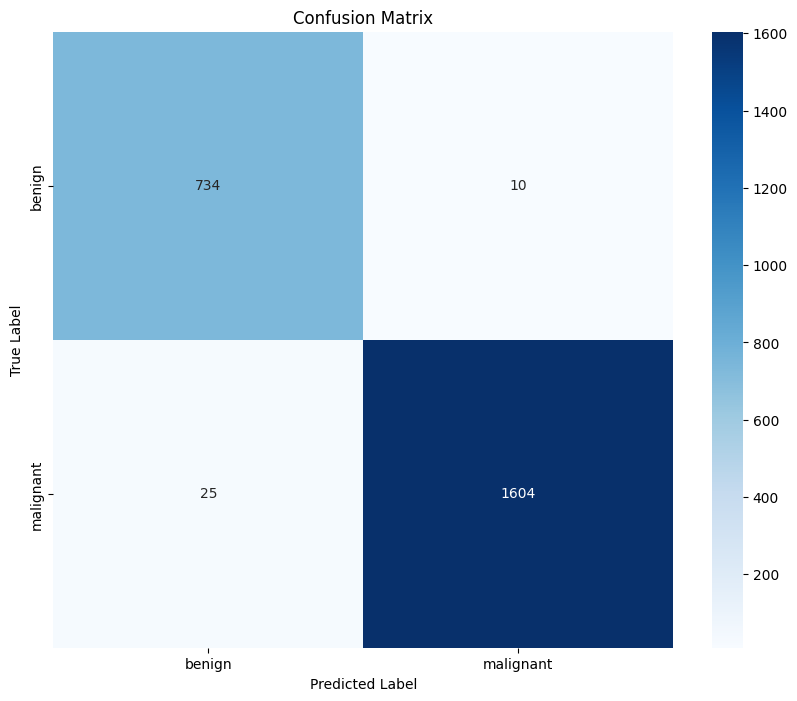

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98       744
   malignant       0.99      0.98      0.99      1629

    accuracy                           0.99      2373
   macro avg       0.98      0.99      0.98      2373
weighted avg       0.99      0.99      0.99      2373



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation phase for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


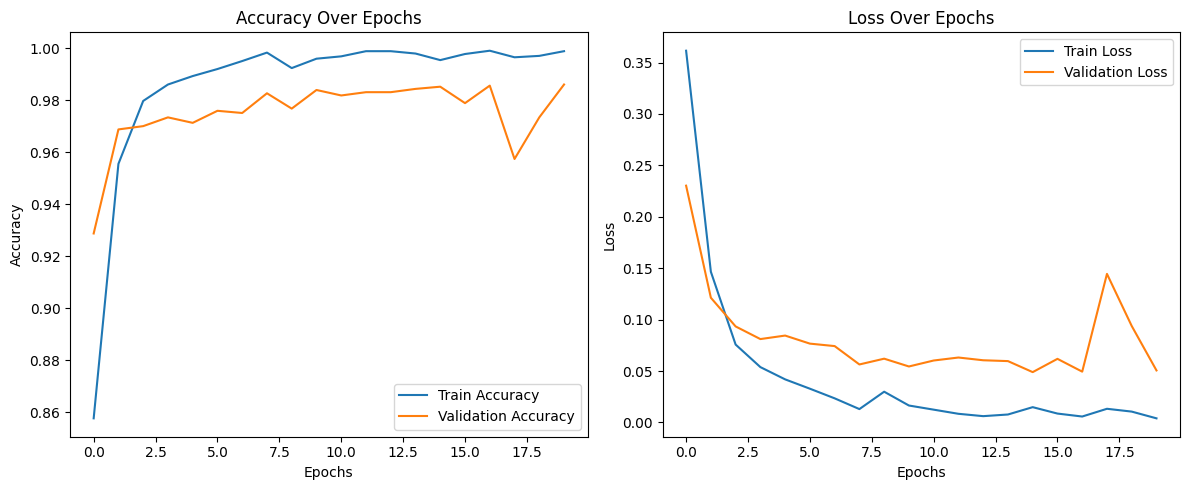

In [11]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


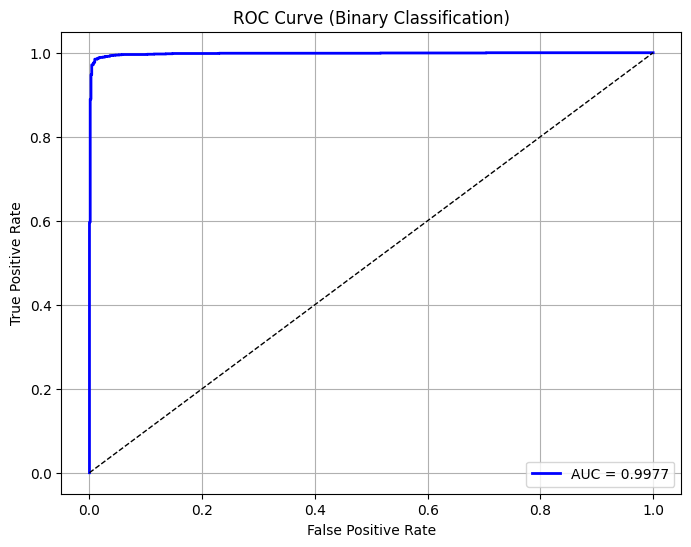

In [14]:
from sklearn.metrics import roc_curve, auc

# Only need the probability for class 1 (positive class)
y_score_bin = y_score[:, 1]  # Assuming second column is "positive"

fpr, tpr, _ = roc_curve(y_true, y_score_bin)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary Classification)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [15]:
def predict_single_image(image_path, model_path='models/best_model.pt', info_path='models/model_info.pt'):
    """
    Load a trained model and make a prediction on a single image.
    
    Args:
        image_path (str): Path to the image file
        model_path (str): Path to the saved model state dict
        info_path (str): Path to the saved model info
        
    Returns:
        prediction (str): Predicted class name
        confidence (float): Confidence score
    """
    from PIL import Image
    
    # Load model info
    model_info = torch.load(info_path)
    class_to_idx = model_info['class_to_idx']
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Initialize model and feature extractor
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=len(class_to_idx)
    )
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor).logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    return idx_to_class[predicted_class.item()], confidence.item()

# Example usage
if __name__ == "__main__":
    # Path to your image (replace with actual path)
    image_path = r"E:\ML_Algorithm\SOB_B_A-14-22549AB-40-002.png"
    
    # Make prediction
    try:
        prediction, confidence = predict_single_image(image_path)
        print(f"Prediction: {prediction}, Confidence: {confidence:.4f}")
    except Exception as e:
        print(f"Error making prediction: {e}")


C:\Users\rjhim\AppData\Local\Temp\ipykernel_11444\2220563375.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load(info_path)
e:\ML_Algorithm\myenv\Li

Prediction: benign, Confidence: 0.9969
